**Universidade Federal de Catal√£o (UFCAT)**  
**Pesquisa de Inicia√ß√£o Cient√≠fica (IC) - ciclo 2021 a 2022**  


---
Autores:  
1. Lucas Cruvinel (***UFCAT***)  
2. Wanderlei Malaquias Pereira Junior (***UFCAT***)  
3. Amanda Campos (***UFRJ***)  
4. Antover P. Sarmento (***UFCAT***)  
5. Daniel Lima Ara√∫jo (***UFG***)  
6. Rog√©rio Espindola (***UFRJ***)  
7. Gustavo de Assis Costa (***IFG***)
---
Este *pipeline* gera uma IA treinada para o problema de predi√ß√£o da resist√™ncia mec√¢nica √† compress√£o de corpos de prova de concreto simples.

Breve descri√ß√£o das vari√°veis:

Atributo           | Unidade   | Nome na cole√ß√£o               | Sigla
---------          | --------- | ---------                     | -------
Cimento            | kg/m¬≥     | Cement                        | $c$  
Esc√≥ria Alto Forno | kg/m¬≥     | blast_furnace_slag            | $bfs$
Cinza Volante      | kg/m¬≥     | fly_ash                       | $fa$
√Ågua               | kg/m¬≥     | water                         | $w$
Superplastificante | kg/m¬≥     | superplasticizer              | $sp$
Agregado Gra√∫do    | kg/m¬≥     | coarse_aggregate              | $cag$
Agregado Fino      | kg/m¬≥     | fine_aggregate                | $fag$
Idade              | dias      | age                           | $t$  
f_ck               | MPa       | concrete_compressive_strength | $f_{ck}$


# Etapa de instala√ß√£o e importa√ß√µes das fontes externas


Instala√ß√£o de bibliotecas n√£o existentes:
- ```xlsxwriter```;
- ```openpyxl```;
- ```emoji```;

_Em caso de necessidade de repetidas execu√ß√µes n√£o √© necess√°rio instalar novamente._

Carregando bibliotecas existentes:
- ```IA```;
- ```numpy```;
- ```pandas```;
- ```seaborn```;
- ```sklearn```.

Lista de emojis
https://unicode.org/emoji/charts/emoji-list.html

In [ ]:
!pip install XlsxWriter
!pip install openpyxl
!pip install emoji

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 153.0/153.0 kB 3.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 356.6/356.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=b77d347aee8d0af32e3c6e50f565e86e00bc3dfad98a34f5d994adcd59fc68be
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xlsxwriter as xw
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from random import randint
import statistics
from math import sqrt
import emoji

In [2]:
# Importa√ß√£o fonte externa
#from IA_COMMON_LIBRARY import *

## **1.1 Carregando o banco de dados do problema**

O banco de dados original foi constru√≠do em uma planilha eletr√¥nica de Excel. A planilha agrupo todos os bancos encontrados nesta pesquisa.

In [4]:
# Leitura do dataset
DF_CONCRETO = pd.read_excel('dataset-full.xlsx')

# Mudan√ßa de alguns nomes de colunas
DF_CONCRETO.rename(columns = {  'Cement':'c',
                                'Water':'w',
                                'BFS':'bd',
                                'FlyAsh': 'fa',
                                'SP': 'sp',
                                'CA': 'cag',
                                'FA': 'fag',
                                'D': 't',
                                'Strength': 'f_ck'
                              }, inplace = True)
DF_CONCRETO.head()

c     bd   fa      w   sp     cag    fag    t       f_ck  Ref
0  540.0    0.0  0.0  162.0  2.5  1040.0  676.0   28  79.986111  Yeh
1  540.0    0.0  0.0  162.0  2.5  1055.0  676.0   28  61.887366  Yeh
2  332.5  142.5  0.0  228.0  0.0   932.0  594.0  270  40.269535  Yeh
3  332.5  142.5  0.0  228.0  0.0   932.0  594.0  365  41.052780  Yeh
4  198.6  132.4  0.0  192.0  0.0   978.4  825.5  360  44.296075  Yeh

## **1.2 Tratamento dos dados**

### 1.2.1 Limpeza dos dados

Devido as caracter√≠sticas deste _dataset_ foi criada uma taxa √°gua-cimento ($a/c$), depois eliminou-se a quantidade de √°gua. As adi√ß√µes de filler tbm foram agrupas em uma coluna.

In [5]:
# Limpeza sim ou n√£o
TRATAMENTO = True

# Execu√ß√£o da limpeza
DF_TRATADO = DF_CONCRETO.copy()

# Execu√ß√£o da limpeza
DF_TRATADO = DF_TRATADO.drop(columns = 'Ref')
DF_TRATADO = DF_TRATADO.drop_duplicates()
if TRATAMENTO:
    # Eliminar registros com idade maior que 28 dias (atributo 'age')
    # DF_TRATADO = DF_TRATADO.drop(DF_TRATADO[DF_TRATADO.t > 28].index)

    # Cria√ß√£o da coluna rela√ß√£o √°gua cimento (a per c) e elimina√ß√£o do atributo √°gua ('water')
    DF_TRATADO['w-c ratio'] = DF_TRATADO['w'] / DF_TRATADO['c']
    DF_TRATADO = DF_TRATADO.drop(columns = ['w'])

    # Juntar colunas dos atributos 'Blast Furnace' e 'Fly Ash' e criar o atributo adi√ß√£o ('add')
    DF_TRATADO['add'] = DF_TRATADO['bd'] + DF_TRATADO['fa']
    DF_TRATADO = DF_TRATADO.drop(columns = ['bd', 'fa'])

    # Eliminar suplesplasticizer (sp)
    # DF_TRATADO = DF_TRATADO.drop(columns = 'sp')

In [6]:
DF_TRATADO.head()

c   sp     cag    fag    t       f_ck  w-c ratio    add
0  540.0  2.5  1040.0  676.0   28  79.986111   0.300000    0.0
1  540.0  2.5  1055.0  676.0   28  61.887366   0.300000    0.0
2  332.5  0.0   932.0  594.0  270  40.269535   0.685714  142.5
3  332.5  0.0   932.0  594.0  365  41.052780   0.685714  142.5
4  198.6  0.0   978.4  825.5  360  44.296075   0.966767  132.4

## **1.3 Descri√ß√£o do banco de dados**

### 1.3.1 Descri√ß√£o estat√≠stica das vari√°veis

In [7]:
DF_TRATADO.describe().transpose()

count         mean         std         min         25%  \
c          2358.0   285.707651  115.037061   38.000000  194.680000   
sp         2358.0     3.751092    5.057820    0.000000    0.000000   
cag        2358.0  1000.156637  121.301509  723.000000  932.000000   
fag        2358.0   724.237171  122.820840  175.950000  645.000000   
t          2358.0    62.591179   86.443705    1.000000    7.000000   
f_ck       2358.0    40.063573   20.140161    1.760000   24.900968   
w-c ratio  2358.0     0.789480    0.439137    0.266893    0.500000   
add        2358.0   128.675237  102.747098    0.000000    0.000000   

                   50%          75%          max  
c           275.000000   375.000000   643.000000  
sp            0.600000     6.860000    32.200000  
cag        1005.600000  1088.550000  1419.300000  
fag         742.000000   798.900000  1066.000000  
t            28.000000    90.000000   365.000000  
f_ck         38.947692    52.737500   113.100000  
w-c ratio     0.703588     0.959648     4.868421  
add         122.580000   200.000000   594.000000

### 1.3.2 Plotagem do histograma das vari√°veis

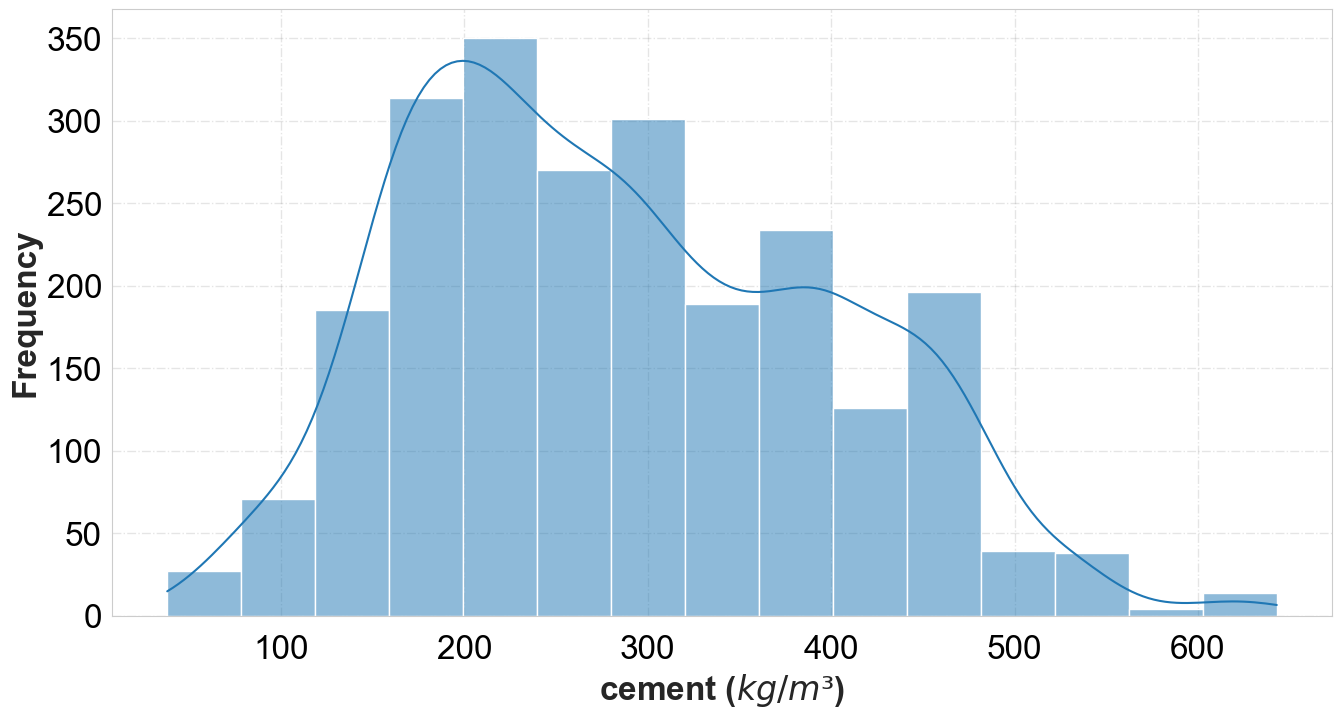

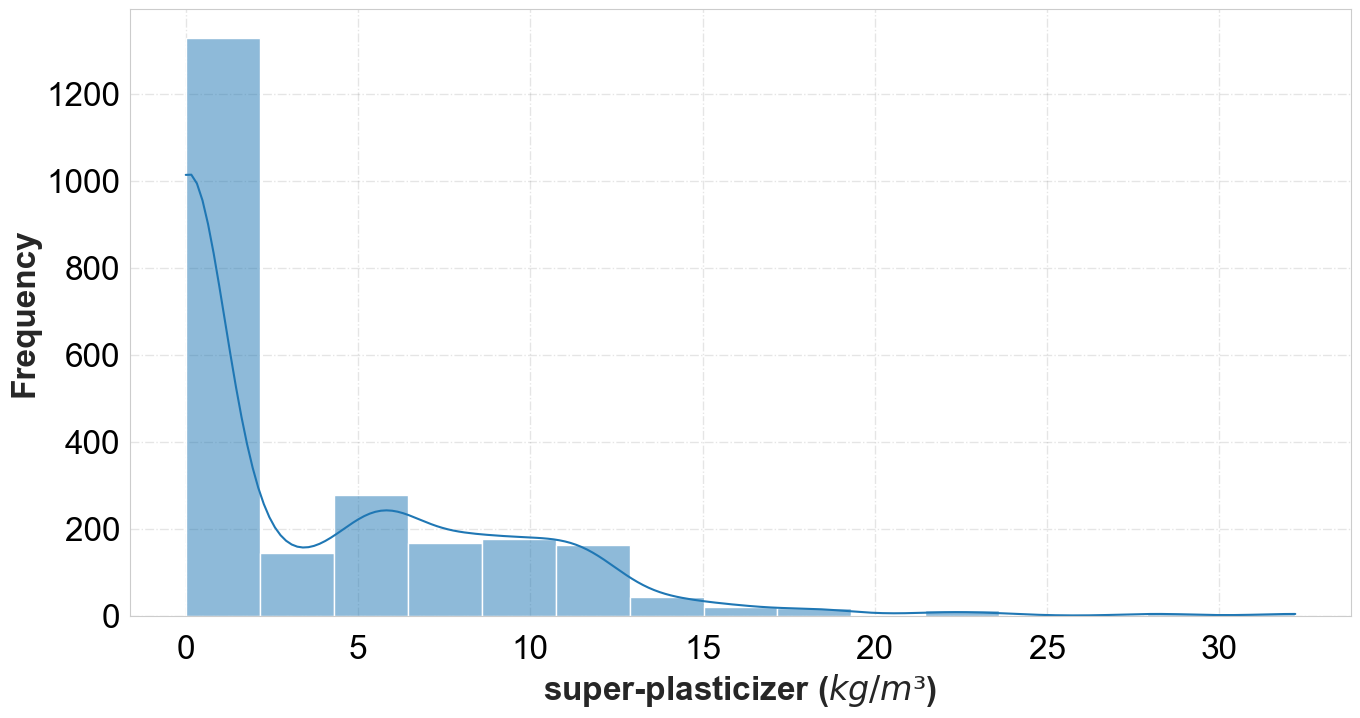

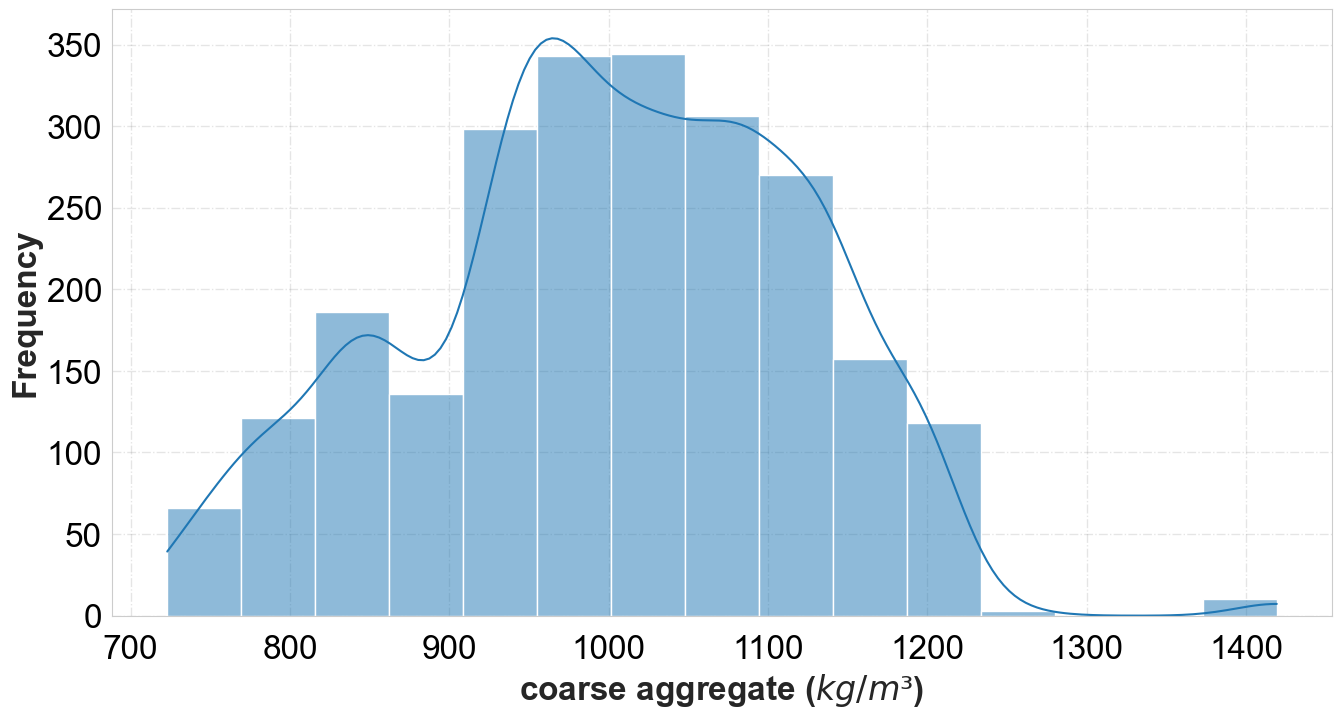

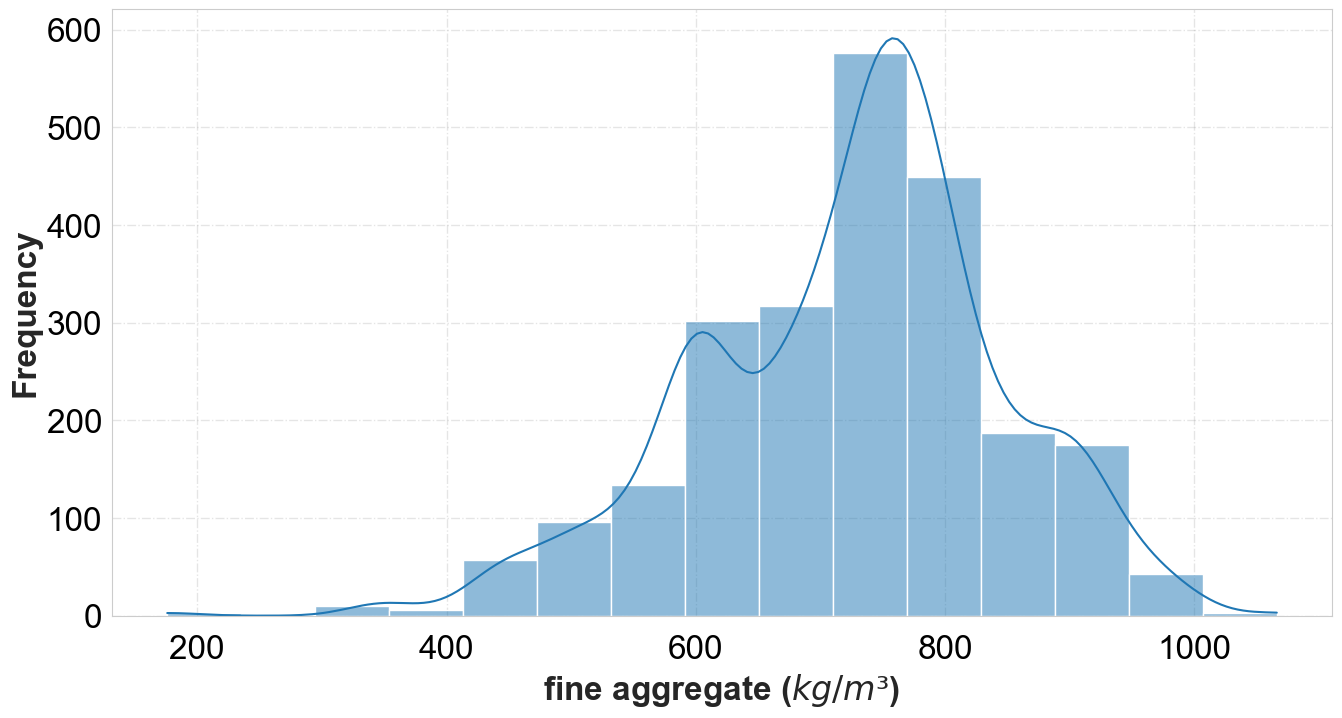

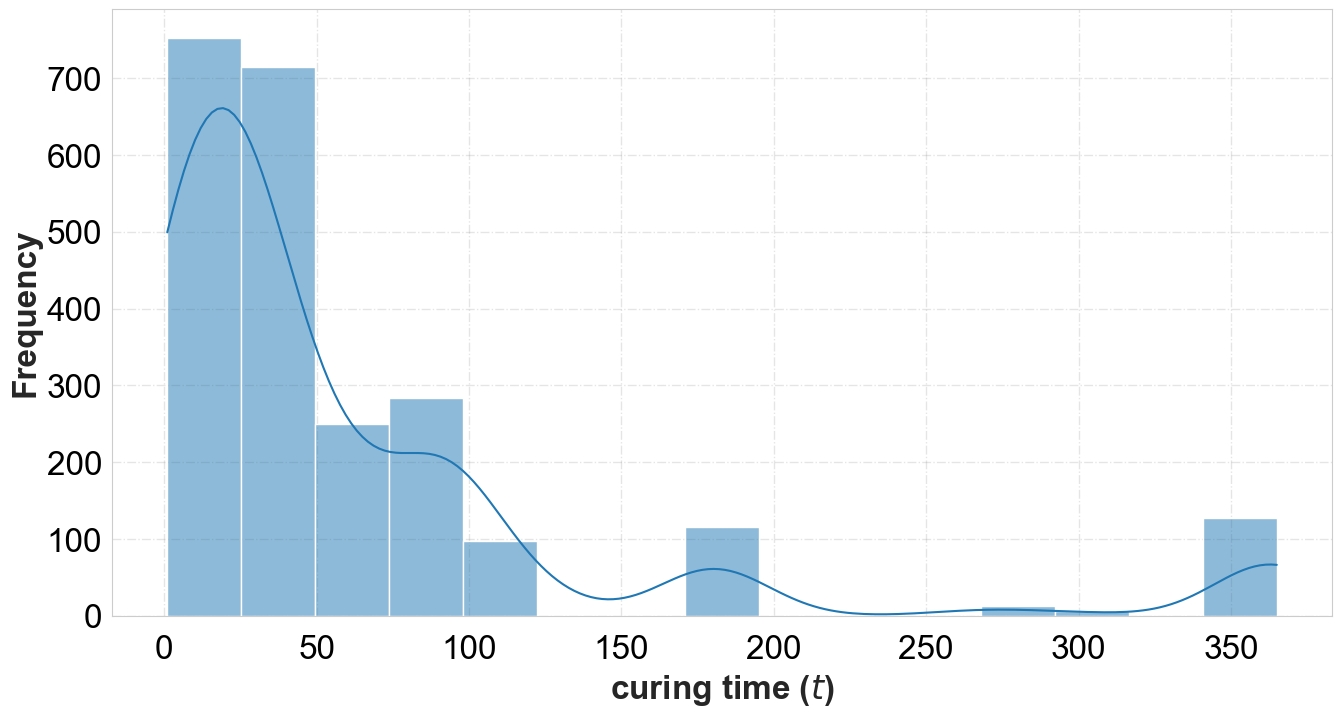

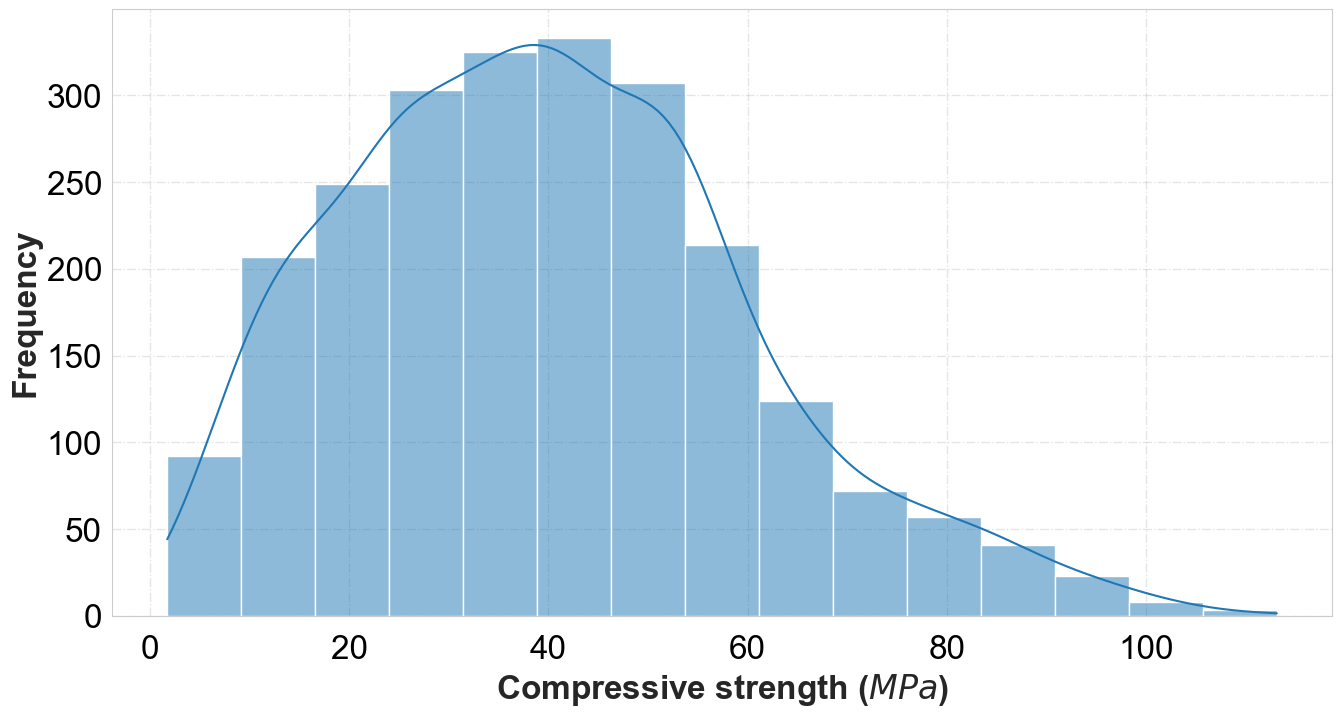

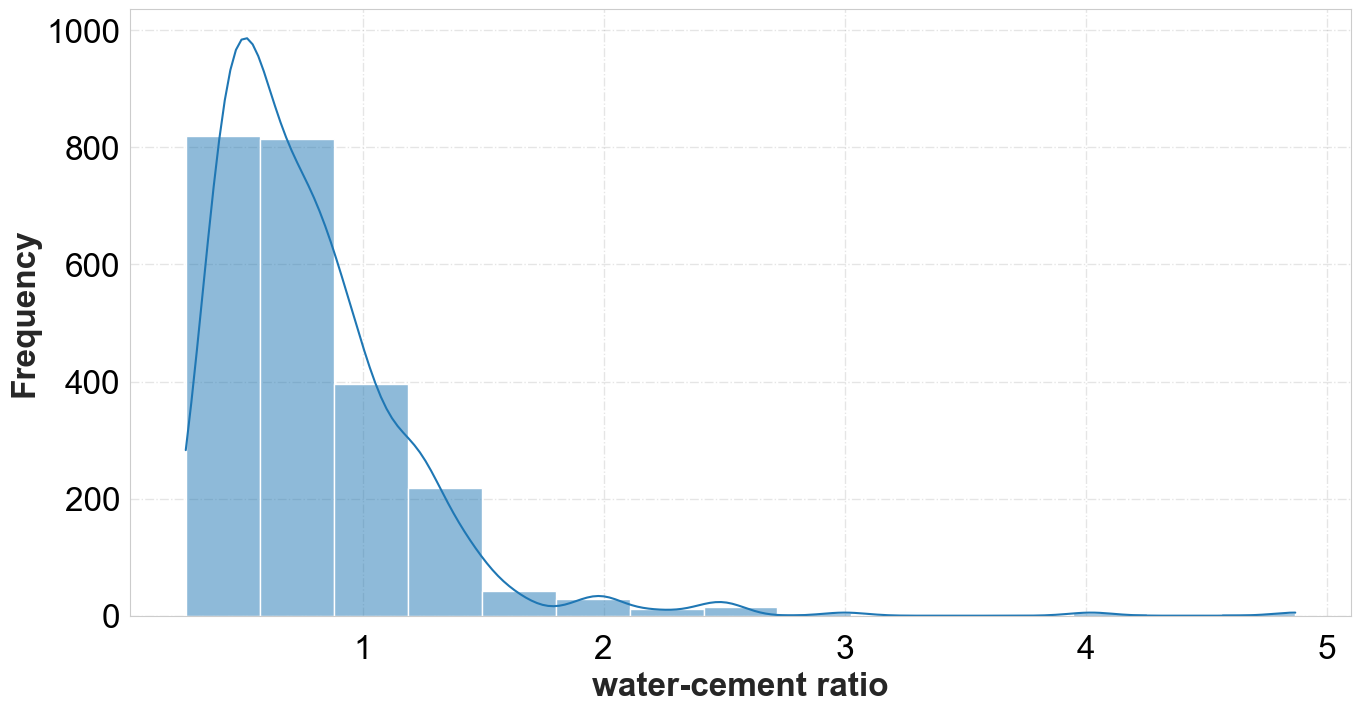

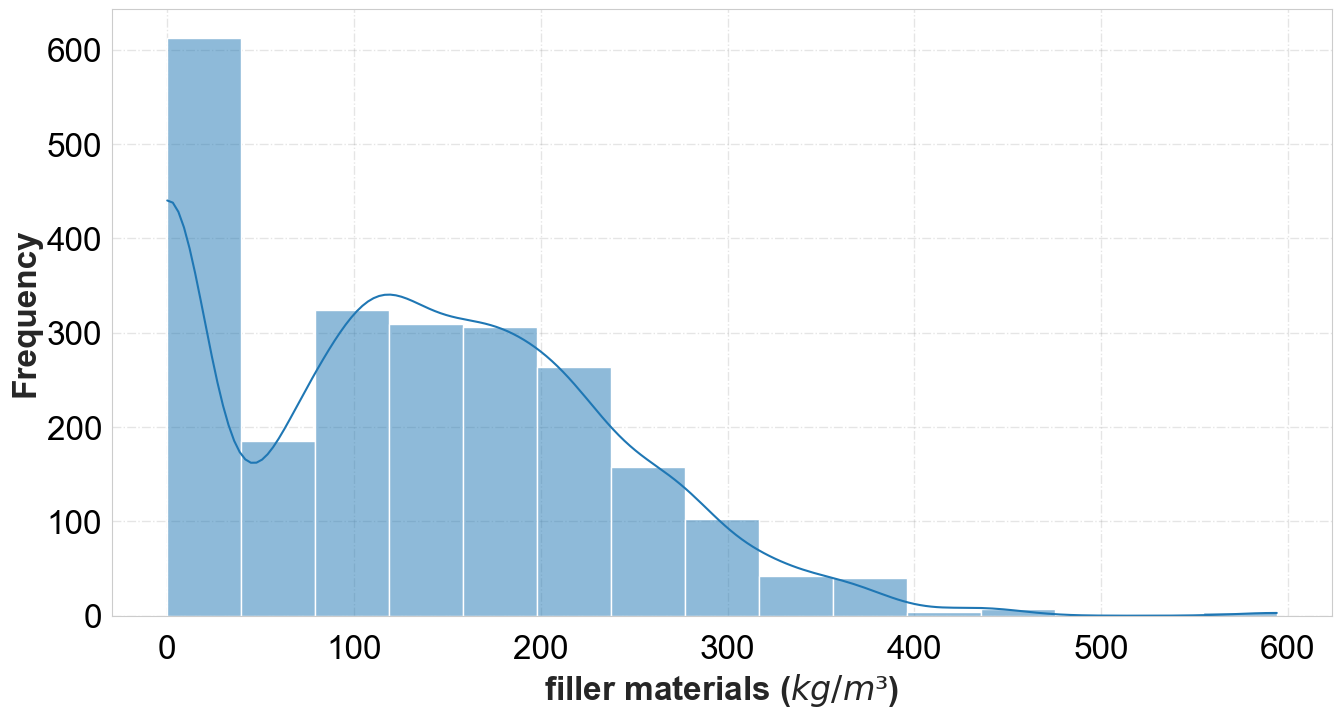

In [12]:
%run Histplot_final.ipynb
LISTA = ['cement ($kg/m¬≥$)',
         'super-plasticizer ($kg/m¬≥$)',
         'coarse aggregate ($kg/m¬≥$)',
         'fine aggregate ($kg/m¬≥$)',
         'curing time ($t$)',
         'Compressive strength ($MPa$)',
         'water-cement ratio',
         'filler materials ($kg/m¬≥$)'
        ]

ID = 0

for COLUMN in DF_TRATADO:
    PLOT_SETUP = {
              'NAME': f'{COLUMN}_hisp',
              'WIDTH': 0.40, 
              'HEIGHT': 0.20,
              'DPI': 600, 
              'EXTENSION': 'jpg',
              'MARKER': 'o',
              'MARKER SIZE': 1.5,
              'Y AXIS LABEL': 'Frequency',
              'X AXIS LABEL': LISTA[ID],
              'LABELS SIZE': 24,
              'LABELS COLOR': '#000000',
              'X AXIS SIZE': 24,
              'Y AXIS SIZE': 24,
              'AXISES COLOR': '#000000',
              'ON GRID?': True,
              'LOC LEGEND': 'upper right',
              'SIZE LEGEND': 14,
              'Y LOG': False,
              'X LOG': False,
              'SMOOTH LINE': True
             }

    DATA = {
            'X': DF_TRATADO[COLUMN]
           }
    HISPLOT(DATA, PLOT_SETUP)
    ID += 1

### 1.3.3 Correla√ß√£o entre as vari√°veis

In [13]:
CORRELACAO = DF_TRATADO.corr()
COR = CORRELACAO.unstack().sort_values(kind = 'quicksort', ascending = False)
print(COR[COR != 1].head(20))
print(COR[COR != 1].tail(20))

add        w-c ratio    0.627349
w-c ratio  add          0.627349
f_ck       t            0.461259
t          f_ck         0.461259
c          f_ck         0.458933
f_ck       c            0.458933
sp         fag          0.277565
fag        sp           0.277565
sp         f_ck         0.244059
f_ck       sp           0.244059
add        sp           0.158224
sp         add          0.158224
f_ck       cag          0.141024
cag        f_ck         0.141024
fag        w-c ratio    0.096437
w-c ratio  fag          0.096437
c          t            0.050140
t          c            0.050140
cag        t            0.036953
t          cag          0.036953
dtype: float64
sp         cag         -0.112760
cag        sp          -0.112760
fag        t           -0.129668
t          fag         -0.129668
w-c ratio  sp          -0.161604
sp         w-c ratio   -0.161604
add        cag         -0.182140
cag        add         -0.182140
f_ck       fag         -0.273507
fag        f_ck        -0.27

In [ ]:
# Plotagem
CONFIG = {'NAME': 'CCS Heatmap',
          'WIDTH': 0.30,
          'HEIGHT': 0.15,
          'X AXIS LABEL': ['c', 'sp', 'cag', 'fag', 't', '$f_{ck}$', '$w / c$', 'add'],
          'Y AXIS LABEL': ['c', 'sp', 'cag', 'fag', 't', '$f_{ck}$', '$w / c$', 'add'],
          'X LABEL ROTATION': 0,
          'Y LABEL ROTATION': 0,
          'LABELS SIZE': 18,
          'LABELS COLOR': '#000000',
          'LINE_WIDTH': 12.00,
          'LINE_COLOR': '#FFFFFF',
          'CENTER COLORMAP': False,
          'ANNOT': False,
          'ANNOT SIZE': 12,
          'ANNOT COLOR': '#FFFFFF',
          'COLORBAR': True,
          'COLORBAR_FONT_SIZE': 15,
          'COLORBAR_OR': 'vertical',
          'COLOR_MAP': 'RdBu',
          'EXTENSION': 'svg',
          'DPI': 600,
         }

DADOS = {'CORR': CORRELACAO}
CORRELATION_CHART(DADOS, CONFIG)

## **1.4 Padroniza√ß√£o dos dados**

Aqui foi empregada a padroniza√ß√£o dos dados do tipo **z-score**.

### 1.4.1 Aplicando a escala Z-score

In [14]:
ESCALAS = DF_TRATADO.describe().loc[['mean','std']]
DF_NORMAL = DF_TRATADO.copy()
for COL in DF_NORMAL:
    if COL != 'f_ck':
        DF_NORMAL[COL] = DF_NORMAL[COL].apply(lambda x: (x - ESCALAS[COL][0]) / ESCALAS[COL][1])
DF_NORMAL

c        sp       cag       fag         t       f_ck  w-c ratio  \
0     2.210525 -0.247358  0.328466 -0.392744 -0.400158  79.986111  -1.114640   
1     2.210525 -0.247358  0.452124 -0.392744 -0.400158  61.887366  -1.114640   
2     0.406759 -0.741642 -0.561878 -1.060383  2.399351  40.269535  -0.236294   
3     0.406759 -0.741642 -0.561878 -1.060383  3.498332  41.052780  -0.236294   
4    -0.757214 -0.741642 -0.179360  0.824476  3.440491  44.296075   0.403719   
...        ...       ...       ...       ...       ...        ...        ...   
2383  1.634016 -0.741642  3.455385 -3.112885 -0.400158  50.810000  -0.932464   
2384  1.222235 -0.741642  3.455385 -3.112885 -0.400158  38.220000  -0.836312   
2385  0.810455 -0.741642  3.455385 -3.112885 -0.400158  27.700000  -0.716119   
2386  0.398761 -0.741642  3.455385 -3.112885 -0.400158  22.520000  -0.561622   
2387 -0.013019 -0.741642  3.455385 -3.112885 -0.400158  21.630000  -0.355585   

           add  
0    -1.252349  
1    -1.252349  
2     0.134551  
3     0.134551  
4     0.036252  
...        ...  
2383 -1.252349  
2384 -0.791314  
2385 -0.330279  
2386  0.130658  
2387  0.591693  

[2358 rows x 8 columns]

### 1.4.2 Escala de convers√£o do _dataset_ original

In [15]:
ESCALAS

c        sp          cag         fag          t       f_ck  \
mean  285.707651  3.751092  1000.156637  724.237171  62.591179  40.063573   
std   115.037061  5.057820   121.301509  122.820840  86.443705  20.140161   

      w-c ratio         add  
mean   0.789480  128.675237  
std    0.439137  102.747098

##  **1.5 Separando os dados em entrada e sa√≠da**

Apresentando o conjunto de dados **$x_i$** e **$y(x_i)$**

In [16]:
COLUNA_Y = 'f_ck'

In [17]:
X = DF_NORMAL.drop(columns = COLUNA_Y)
Y = pd.DataFrame(DF_NORMAL[COLUNA_Y], columns = [COLUNA_Y])

### 1.5.1 Vari√°veis independentes ($x$)

In [18]:
X.head()

c        sp       cag       fag         t  w-c ratio       add
0  2.210525 -0.247358  0.328466 -0.392744 -0.400158  -1.114640 -1.252349
1  2.210525 -0.247358  0.452124 -0.392744 -0.400158  -1.114640 -1.252349
2  0.406759 -0.741642 -0.561878 -1.060383  2.399351  -0.236294  0.134551
3  0.406759 -0.741642 -0.561878 -1.060383  3.498332  -0.236294  0.134551
4 -0.757214 -0.741642 -0.179360  0.824476  3.440491   0.403719  0.036252

### 1.5.2 Vari√°vel dependente ($y$)




In [19]:
Y.head()

f_ck
0  79.986111
1  61.887366
2  40.269535
3  41.052780
4  44.296075

## **1.6 Cria√ß√£o dos modelos de aprendizado de m√°quina**

Nesta se√ß√£o ser√° criada uma lista com os modelos de IA que iremos empregar. A posi√ß√£o da lista √© formada pelos seguintes fatores:

0. Config modelo;
1. Nome modelo;
2. Valida√ß√£o Cruzada;
3. Treino;
4. Teste;

In [20]:
MODELOS = [
            [LinearRegression(), "Regress√£o Linear 1¬∞", None, None, None, 'Regress√£o', 1],
            [LinearRegression(), "Regress√£o N√£o Linear 2¬∞", None, None, None, 'Regress√£o', 2],
            [LinearRegression(), "Regress√£o N√£o Linear 3¬∞", None, None, None, 'Regress√£o', 3],
            [Ridge(), "Regress√£o Ridge Linear 1¬∞", None, None, None, 'Regress√£o', 1],
            [Ridge(), "Regress√£o Ridge N√£o Linear 2¬∞", None, None, None, 'Regress√£o', 2],
            [Ridge(), "Regress√£o Ridge N√£o Linear 3¬∞", None, None, None, 'Regress√£o', 3],
            [DecisionTreeRegressor(max_depth = 2), "√Årvore de decis√£o prof 2", None, None, None, '√Årvore', 2],
            [DecisionTreeRegressor(max_depth = 5), "√Årvore de decis√£o prof 5", None, None, None, '√Årvore', 5],
            [DecisionTreeRegressor(max_depth = 10), "√Årvore de decis√£o prof 10", None, None, None, '√Årvore', 10],
            [DecisionTreeRegressor(max_depth = 20), "√Årvore de decis√£o prof 20", None, None, None, '√Årvore', 20],
            [GradientBoostingRegressor(n_estimators = 10, max_depth = 10), "Gradiente Boosting 10 10", None, None, None, 'Ensemble', 10],
            [GradientBoostingRegressor(n_estimators = 50, max_depth = 10), "Gradiente Boosting 50 10", None, None, None, 'Ensemble', 50],
            [GradientBoostingRegressor(n_estimators = 100, max_depth = 10), "Gradiente Boosting 100 10", None, None, None, 'Ensemble', 100],
            [GradientBoostingRegressor(n_estimators = 100, max_depth = 20), "Gradiente Boosting 100 20", None, None, None, 'Ensemble', 100],
            [GradientBoostingRegressor(n_estimators = 500, max_depth = 20), "Gradiente Boosting 500 20", None, None, None, 'Ensemble', 500]
          ]

QUANT_MODELOS, _ = np.shape(MODELOS)

## **1.7 Curva de aprendizado para determina√ß√£o do tamanho da parcela de treino**

In [ ]:
CURVA_PRENDIZADO = True
if CURVA_PRENDIZADO:
    print('\U0001F4C3' + 'Modelos que geraram curva de aprendizado: \n')
    for I_CONT in range(len(MODELOS)):
        NOME = 'Curva de aprendizado ' + MODELOS[I_CONT][1]
        CONFIG = {
             'NAME': NOME,
             'WIDTH': 0.20,
             'HEIGHT': 0.10,
             'X AXIS SIZE': 15,
             'Y AXIS SIZE': 15,
             'X AXIS LABEL': 'Training set size (%)',
             'Y AXIS LABEL': '$RMSE$',
             'AXISES COLOR': '#000000',
             'LABELS SIZE': 15,
             'LABELS COLOR': '#000000',
             'COLOR TRAIN': '#F53725',
             'COLOR VALID': '#2219F0',
             'LINE STYLE': '-',
             'LINE WIDTH': 4,
             'MARKER STYLE': None,
             'MARKER SIZE': None,
             'EXTENSION': '.svg',
             'DPI': 600,
             'LEGEND SIZE': 15,
             'LEGEND LOC': 'best'
             }
        DADOS = {
            'X': X,
            'Y': Y,
            'MODEL': MODELOS[I_CONT],
            'REGRESSION': MODELOS[I_CONT][1]
        }
        print('Modelo: ', MODELOS[I_CONT][1])
        LEARNING_RATE_CHART(DADOS, CONFIG)

## **1.8 Valida√ß√£o cruzada iterativa**

Separa√ß√£o treino e teste

In [21]:
X_TREINO, X_TESTE, Y_TREINO, Y_TESTE  = train_test_split(X, Y, train_size = 0.80, shuffle = True)
Y_TREINO = np.ravel(Y_TREINO)
Y_TESTE = np.ravel(Y_TESTE)

In [22]:
NUM_SEMENTES = 30
SEMENTES = [randint(0, 100) for N in range(NUM_SEMENTES)]

RESULTADOS_VC_SEMENTES = np.zeros((NUM_SEMENTES, QUANT_MODELOS + 1))
ITER = 0

# Valida√ß√£o cruzada com altera√ß√£o da seed
for I_CONT, SEED in enumerate(SEMENTES):
    # Configura√ß√£o do Kfold
    KFOLD = KFold(n_splits = 10, shuffle = True, random_state = SEED)

    # Configura√ß√£o para resultados
    RESULTADOS_VC_SEMENTES[I_CONT, 0] = SEED

    # Valida√ß√£o cruzada
    for J_CONT in range(len(MODELOS)):
        # Carregando o modelo
        MODELO = MODELOS[J_CONT][0]
        if MODELOS[J_CONT][5] == 'Regress√£o':
            GRAU_POLI = MODELOS[J_CONT][6]
            PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
        else:
            PIPELINE = MODELO

        # Valida√ß√£o do modelo
        RESULTADO_VC = cross_val_score(PIPELINE, X_TREINO, Y_TREINO, cv = KFOLD, scoring = "r2", n_jobs = -1)

        # M√©dia dos resultados para uma valida√ß√£o cruzado com n kfolds
        MEDIA_R2VC = np.mean(RESULTADO_VC)

        # Armazenando os resultados
        RESULTADOS_VC_SEMENTES[I_CONT, J_CONT + 1] = MEDIA_R2VC

### 1.8.1 Transformando o _dataset_ de valida√ß√£o cruzada em uma planilha Excel

Estat√≠sticas da valida√ß√£o cruzada





In [23]:
COLUNAS_NOME = ['seed']
for I in range(QUANT_MODELOS):
    COLUNAS_NOME.append(MODELOS[I][1])
RESULTADOS_GERAIS_VC = pd.DataFrame(RESULTADOS_VC_SEMENTES)
RESULTADOS_GERAIS_VC.columns = COLUNAS_NOME
RESULTADOS_GERAIS_VC.describe().transpose()

count       mean        std       min  \
seed                            30.0  45.666667  31.668905  0.000000   
Regress√£o Linear 1¬∞             30.0   0.598190   0.001979  0.592376   
Regress√£o N√£o Linear 2¬∞         30.0   0.774449   0.001544  0.771068   
Regress√£o N√£o Linear 3¬∞         30.0   0.845187   0.011499  0.800830   
Regress√£o Ridge Linear 1¬∞       30.0   0.598197   0.001981  0.592383   
Regress√£o Ridge N√£o Linear 2¬∞   30.0   0.774495   0.001530  0.771166   
Regress√£o Ridge N√£o Linear 3¬∞   30.0   0.846817   0.008216  0.815943   
√Årvore de decis√£o prof 2        30.0   0.455169   0.009897  0.434973   
√Årvore de decis√£o prof 5        30.0   0.708626   0.003923  0.702131   
√Årvore de decis√£o prof 10       30.0   0.798875   0.007139  0.786762   
√Årvore de decis√£o prof 20       30.0   0.803295   0.009237  0.782841   
Gradiente Boosting 10 10        30.0   0.758494   0.005303  0.750885   
Gradiente Boosting 50 10        30.0   0.882422   0.004657  0.875812   
Gradiente Boosting 100 10       30.0   0.884746   0.004692  0.878049   
Gradiente Boosting 100 20       30.0   0.816732   0.007758  0.798867   
Gradiente Boosting 500 20       30.0   0.817139   0.007615  0.800000   

                                     25%        50%        75%        max  
seed                           16.250000  41.000000  70.750000  98.000000  
Regress√£o Linear 1¬∞             0.597381   0.598026   0.599436   0.603271  
Regress√£o N√£o Linear 2¬∞         0.773597   0.774570   0.775420   0.778370  
Regress√£o N√£o Linear 3¬∞         0.847174   0.849590   0.850254   0.852144  
Regress√£o Ridge Linear 1¬∞       0.597386   0.598040   0.599447   0.603289  
Regress√£o Ridge N√£o Linear 2¬∞   0.773676   0.774585   0.775450   0.778412  
Regress√£o Ridge N√£o Linear 3¬∞   0.846952   0.849722   0.850736   0.852658  
√Årvore de decis√£o prof 2        0.449022   0.456204   0.462459   0.470927  
√Årvore de decis√£o prof 5        0.705903   0.708320   0.710350   0.720430  
√Årvore de decis√£o prof 10       0.794388   0.798742   0.802749   0.817150  
√Årvore de decis√£o prof 20       0.797223   0.803536   0.806989   0.826756  
Gradiente Boosting 10 10        0.753984   0.758245   0.761307   0.770887  
Gradiente Boosting 50 10        0.879047   0.882237   0.884545   0.892297  
Gradiente Boosting 100 10       0.880733   0.884378   0.887606   0.895905  
Gradiente Boosting 100 20       0.812452   0.817043   0.818609   0.836677  
Gradiente Boosting 500 20       0.812430   0.817045   0.819096   0.836378

Salvando os dados da m√©dia da valida√ß√£o cruzada iterativa

In [24]:
ESTATISTICA_VC = RESULTADOS_GERAIS_VC.describe().transpose()
for I in range(QUANT_MODELOS):
    MODELOS[I][2] = ESTATISTICA_VC['mean'][I + 1]

Impress√£o dos dados para teste T

In [ ]:
RESULTADOS_GERAIS_VC.to_excel('Valida√ß√£o cruzada iterativa completa.xlsx', index = False)

## 1.9 Treinamento, teste e teste externo

In [26]:
# Treino / teste
#for J_CONT in range(1):
for J_CONT in range(len(MODELOS)):
    # Carregando o modelo
    MODELO = MODELOS[J_CONT][0]
    if (MODELOS[J_CONT][5] == 'Regress√£o' or MODELOS[J_CONT][5] == 'Regression'):
        GRAU_POLI = MODELOS[J_CONT][6]
        PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
    else:
        PIPELINE = MODELO

    # Treinamento
    PIPELINE.fit(X_TREINO, Y_TREINO)

    # Acur√°cia do treino
    Y_PREDTREINO = PIPELINE.predict(X_TREINO)
    R2_TREINO = r2_score(Y_TREINO, Y_PREDTREINO)

    # Acur√°cia do teste
    Y_PREDTESTE = PIPELINE.predict(X_TESTE)
    R2_TESTE = r2_score(Y_TESTE, Y_PREDTESTE)

    # Armazenando os resultados
    MODELOS[J_CONT][3] = R2_TREINO
    MODELOS[J_CONT][4] = R2_TESTE

    # Impress√µes no console
    print('\U0001F3AF' + 'Modelo: ' + MODELOS[J_CONT][1] + ' \n ' + 'r^2 acur√°cia treino: %.3f \n r^2 acur√°cia teste: %.3f' % (R2_TREINO * 100, R2_TESTE * 100), '\n')

    # ScatterPlot
    Y_NUM = PIPELINE.predict(X)
    DATASET = {'Y_OBS': Y.values.ravel().tolist(), 'Y_PRED': Y_NUM.tolist()}

    PLOT_SETUP = {
        'NAME': f'scatterplot_model_{MODELOS[J_CONT][1]}',
        'EXTENSION': 'svg',
        'DPI': 600,
        'WIDTH': 0.20,
        'HEIGHT': 0.10,
        'X AXIS LABEL': 'Observed values',
        'Y AXIS LABEL': 'Predicted values',
        'ALPHA': 0.2,
        'LINE COLOR': 'r',
        'LINE WIDTH': 3,
        'SCATTER COLOR': '#33FF6E',
        'MARKER': 'o',
        'LABEL FONTSIZE': 20,
        'LABEL SIZE': 20,
        'LABEL COLOR': '#000000'
    }

    #COMPARE_PREDICTED_OBSERVED(DATASET, PLOT_SETUP)

üéØModelo: Regress√£o Linear 1¬∞ 
 r^2 acur√°cia treino: 60.632 
 r^2 acur√°cia teste: 60.708 

üéØModelo: Regress√£o N√£o Linear 2¬∞ 
 r^2 acur√°cia treino: 78.723 
 r^2 acur√°cia teste: 75.571 

üéØModelo: Regress√£o N√£o Linear 3¬∞ 
 r^2 acur√°cia treino: 87.627 
 r^2 acur√°cia teste: 85.662 

üéØModelo: Regress√£o Ridge Linear 1¬∞ 
 r^2 acur√°cia treino: 60.632 
 r^2 acur√°cia teste: 60.715 

üéØModelo: Regress√£o Ridge N√£o Linear 2¬∞ 
 r^2 acur√°cia treino: 78.718 
 r^2 acur√°cia teste: 75.604 

üéØModelo: Regress√£o Ridge N√£o Linear 3¬∞ 
 r^2 acur√°cia treino: 87.508 
 r^2 acur√°cia teste: 85.679 

üéØModelo: √Årvore de decis√£o prof 2 
 r^2 acur√°cia treino: 48.222 
 r^2 acur√°cia teste: 39.266 

üéØModelo: √Årvore de decis√£o prof 5 
 r^2 acur√°cia treino: 75.800 
 r^2 acur√°cia teste: 65.420 

üéØModelo: √Årvore de decis√£o prof 10 
 r^2 acur√°cia treino: 96.013 
 r^2 acur√°cia teste: 80.702 

üéØModelo: √Årvore de decis√£o prof 20 
 r^2 acur√°cia treino: 99.821 
 

## 1.10 Impress√£o em planilha dos resultados

In [27]:
RESULTADO_GERAL = pd.DataFrame(MODELOS)
RESULTADO_GERAL.columns = ['modelo', 'obs_1', 'vc', 'treino', 'teste', 'tipologia', 'obs_2']
RESULTADO_GERAL['media'] = (RESULTADO_GERAL['vc'] + RESULTADO_GERAL['teste']) / 2
RESULTADO_GERAL

modelo  \
0                                  LinearRegression()   
1                                  LinearRegression()   
2                                  LinearRegression()   
3                                             Ridge()   
4                                             Ridge()   
5                                             Ridge()   
6                  DecisionTreeRegressor(max_depth=2)   
7                  DecisionTreeRegressor(max_depth=5)   
8                 DecisionTreeRegressor(max_depth=10)   
9                 DecisionTreeRegressor(max_depth=20)   
10  ([DecisionTreeRegressor(criterion='friedman_ms...   
11  ([DecisionTreeRegressor(criterion='friedman_ms...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                            obs_1        vc    treino     teste  tipologia  \
0             Regress√£o Linear 1¬∞  0.598190  0.606325  0.607080  Regress√£o   
1         Regress√£o N√£o Linear 2¬∞  0.774449  0.787229  0.755708  Regress√£o   
2         Regress√£o N√£o Linear 3¬∞  0.845187  0.876266  0.856624  Regress√£o   
3       Regress√£o Ridge Linear 1¬∞  0.598197  0.606322  0.607150  Regress√£o   
4   Regress√£o Ridge N√£o Linear 2¬∞  0.774495  0.787176  0.756041  Regress√£o   
5   Regress√£o Ridge N√£o Linear 3¬∞  0.846817  0.875081  0.856792  Regress√£o   
6        √Årvore de decis√£o prof 2  0.455169  0.482219  0.392665     √Årvore   
7        √Årvore de decis√£o prof 5  0.708626  0.757999  0.654201     √Årvore   
8       √Årvore de decis√£o prof 10  0.798875  0.960130  0.807019     √Årvore   
9       √Årvore de decis√£o prof 20  0.803295  0.998206  0.816260     √Årvore   
10       Gradiente Boosting 10 10  0.758494  0.857389  0.749169   Ensemble   
11       Gradiente Boosting 50 10  0.882422  0.997748  0.872047   Ensemble   
12      Gradiente Boosting 100 10  0.884746  0.998160  0.876337   Ensemble   
13      Gradiente Boosting 100 20  0.816732  0.998206  0.820775   Ensemble   
14      Gradiente Boosting 500 20  0.817139  0.998206  0.817699   Ensemble   

    obs_2     media  
0       1  0.602635  
1       2  0.765078  
2       3  0.850905  
3       1  0.602674  
4       2  0.765268  
5       3  0.851805  
6       2  0.423917  
7       5  0.681414  
8      10  0.802947  
9      20  0.809777  
10     10  0.753832  
11     50  0.877234  
12    100  0.880542  
13    100  0.818754  
14    500  0.817419

## 1.11 Salvando o melhor modelo

### 1.11.1 Salvando o modelo de IA

Foi considerada como refer√™ncia para salvar o modelo o desempenho m√©dio da valida√ß√£o cruzada e do teste.

In [29]:
INDEX_MELHOR = RESULTADO_GERAL.index[RESULTADO_GERAL['media'] == RESULTADO_GERAL['media'].max()].tolist()[0]
print(INDEX_MELHOR)
MELHOR_MODELO = MODELOS[INDEX_MELHOR]
MELHOR_MODELO

12


[GradientBoostingRegressor(max_depth=10),
 'Gradiente Boosting 100 10',
 0.8847461217205457,
 0.998160114409747,
 0.876337494208841,
 'Ensemble',
 100]

In [30]:
MELHOR_MODELO[0]

GradientBoostingRegressor(max_depth=10)

A extens√£o do arquivo SAV √© mais comumente conhecido como uma extens√£o gen√©rico que √© usado para salvar arquivos e dados"

In [34]:
import joblib
from sklearn.pipeline import make_pipeline
#PIPELINE = make_pipeline(PolynomialFeatures(degree = 2), MELHOR_MODELO[0])
MODELO = MELHOR_MODELO[0]
if (MODELOS[J_CONT][5] == 'Regress√£o' or MODELOS[J_CONT][5] == 'Regression'):
    GRAU_POLI = MODELOS[J_CONT][6]
    PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
else:
    PIPELINE = MODELO
        
# Treinamento
PIPELINE.fit(X_TREINO, Y_TREINO)

# Acur√°cia do treino
Y_PREDTREINO = PIPELINE.predict(X_TREINO)
R2_TREINO = r2_score(Y_TREINO, Y_PREDTREINO)
        
# Acur√°cia do teste
Y_PREDTESTE = PIPELINE.predict(X_TESTE)
R2_TESTE = r2_score(Y_TESTE, Y_PREDTESTE)
#print(R2_TESTE)
#print(R2_TREINO)
#joblib.dump(PIPELINE, 'melhor_modelo.pkl')
import pickle
with open('melhor_modelo_concrete.pkl', 'wb') as file:
    pickle.dump(PIPELINE, file)

print("R2 treino = ",R2_TREINO)
print("R2 teste = ", R2_TESTE)

R2 treino =  0.998160114409747
R2 teste =  0.8769399020414455


In [31]:
CONCRETE_MODELO = "model.sav"
pickle.dump(MELHOR_MODELO, open(CONCRETE_MODELO, 'wb'))

### 1.11.2 Salvando a escala do modelo de IA

In [32]:
nome_arquivo = "scale_concrete.sav"
pickle.dump(ESCALAS, open(nome_arquivo, 'wb'))